# Memorizing elements of a sequence

The goal of this task is to memorize some specific elements of a sequence a symbols with variable length. This toy example is useful to test the capacity of RNNs to keep representations in memory over long sequences.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## One-hot encoding for string of symbols

In [2]:
ALPHABET = np.asarray(list("abcd"), dtype=object)


def symbols_to_binarray(s, alphabet=ALPHABET, dtype=np.float32):
    """One-hot encode a sequence of symbols
    
    This numerical representation of a string of symbols is useful
    to feed the data and expected labels to the input and output
    layers of recurrent networks.
    """
    alphabet = np.asarray(list(alphabet), dtype=object)
    n_samples = len(s)
    n_features = len(alphabet)

    mapping = dict(zip(alphabet, range(n_features)))
    
    code = np.zeros((n_samples, n_features), dtype=dtype)
    for i, e in enumerate(s):
        code[i, mapping[e]] = 1.0
    return code

In [3]:
symbol_sequence = "abcdacbd"
encoded_sequence = symbols_to_binarray(symbol_sequence)
encoded_sequence

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.]], dtype=float32)

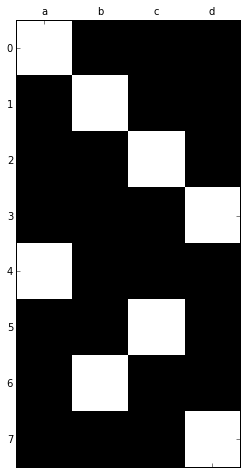

In [4]:
def plot_encoded_sequence(encoded_sequence, alphabet=ALPHABET):
    plt.matshow(encoded_sequence, cmap=plt.cm.gray)
    plt.xticks(np.arange(len(ALPHABET)), alphabet)
    
plot_encoded_sequence(encoded_sequence)

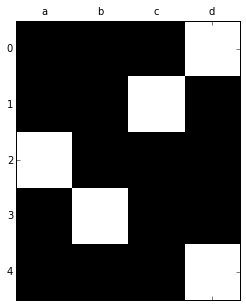

In [5]:
plot_encoded_sequence(symbols_to_binarray('dcabd'))

## Decoding back to a sequence of symbols

In [6]:
def binarray_to_symbols(code, alphabet=ALPHABET):
    """Convert encoded data by to a string of symbols"""
    n_samples, n_features = code.shape
    if n_features != len(alphabet):
        raise ValueError(
            "code should have %d columns (instead of %d)."
            % (len(alphabet), n_features)
        )

    # Make sure that the alphabet is a numpy array of symbols
    # to make it possible to leverage numpy fancy indexing
    if not isinstance(alphabet, np.ndarray):
        alphabet = np.asarray(list(alphabet), dtype='object')

    return "".join(alphabet[code.argmax(axis=1)])

In [7]:
binarray_to_symbols(encoded_sequence)

'abcdacbd'

## Generating data for a simple memory task

The goal of this task is to output the 2nd and 5th element of random input sequences.

To solve it, the RNN has to rember the current position (count the element of the sequence) and store some representation of the 2nd and 5th element in its recurrent layer activations.  This task can be made artificially hard by increasing the average lentgh of the sequences as it is likely to be harder to memorize old events.

In [8]:
def generate_sequences(n_sequences=1000, min_length=5, max_length=15,
                       alphabet=ALPHABET, seed=None):
    sequences = []
    rng = np.random.RandomState(seed)
    for i in range(n_sequences):
        length = rng.randint(min_length, max_length)
        sequences.append("".join(rng.choice(ALPHABET, length)))
    return sequences

In [9]:
generate_sequences(n_sequences=5, min_length=5, max_length=15, seed=0)

['addddbdbca', 'caaacbcddcab', 'bbabadadbc', 'cdabd', 'dcdabbbd']

Let's generate the sequences as a data array padded with zeros.

In [10]:
def generate_data(n_sequences=1000, min_length=5, max_length=15,
                  alphabet=ALPHABET, seed=None):
    
    # Generate the input sequences as symbols
    input_sequences = generate_sequences(
        n_sequences=n_sequences, min_length=min_length,
        max_length=max_length, alphabet=alphabet, seed=seed)
    output_sequences = []
    
    # 2 steps are used for the expected output
    n_steps_per_sequence = (max_length + 2)

    # Allocate all the data arrays at once and pad with zeros
    n_features = len(alphabet)
    input_data = np.zeros((n_sequences, n_steps_per_sequence, n_features),
                          dtype=np.float32)
    output_data = np.zeros((n_sequences, n_steps_per_sequence, n_features),
                           dtype=np.float32)
    
    for sequence_idx, input_sequence in enumerate(input_sequences):
        # store the encoded sequence to the input tape
        encoded_input = symbols_to_binarray(input_sequence)
        input_data[sequence_idx, 0:len(input_sequence)] = encoded_input
        
        # store the encoded output to the output tape by taking
        # the 2nd and 5th symbols of the input sequence
        output_sequence = input_sequence[1] + input_sequence[4]
        output_sequences.append(output_sequence)
        encoded_output = symbols_to_binarray(output_sequence)
        start = len(input_sequence)
        stop = start + 2
        output_data[sequence_idx, start:stop] = encoded_output
        
    return input_sequences, output_sequences, input_data, output_data

Let's try it to generate a toy dataset:

In [11]:
input_sequences, output_sequences, input_data, output_data = generate_data(n_sequences=10, seed=0)

In [12]:
zip(input_sequences, output_sequences)

[('addddbdbca', 'dd'),
 ('caaacbcddcab', 'ac'),
 ('bbabadadbc', 'ba'),
 ('cdabd', 'dd'),
 ('dcdabbbd', 'cb'),
 ('dcadd', 'cd'),
 ('dacaaab', 'aa'),
 ('caabdabccd', 'ad'),
 ('bbdbbdcddccda', 'bb'),
 ('babcadac', 'aa')]

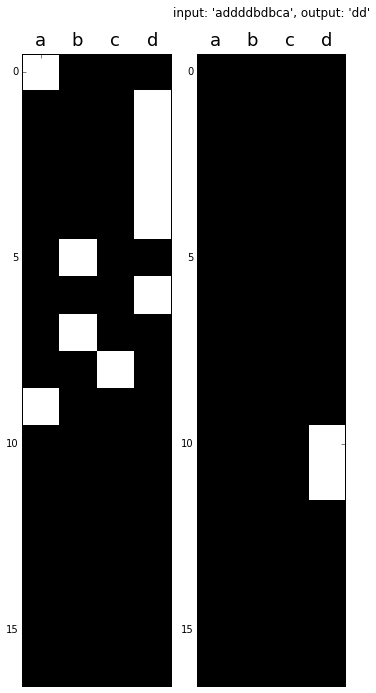

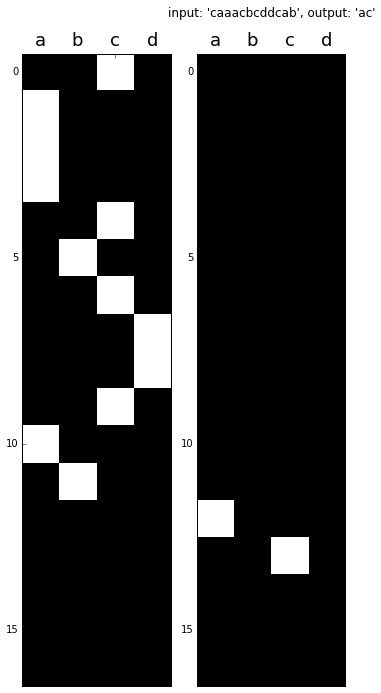

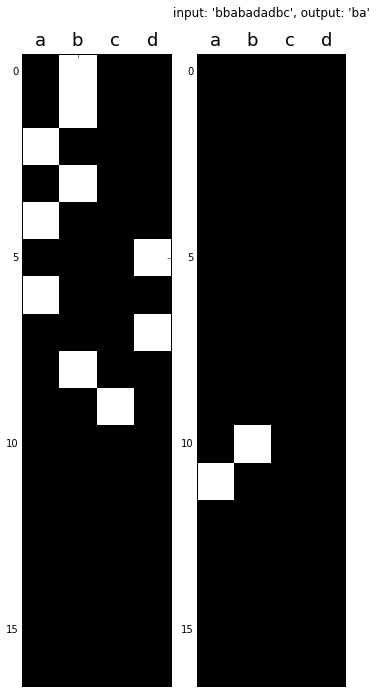

In [13]:
for i in range(3):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 10))
    for ax, data in zip(axes, [input_data[i], output_data[i]]):
        ax.matshow(data, cmap=plt.cm.gray)
        ax.set_xticks(np.arange(len(ALPHABET)))
        ax.set_xticklabels(ALPHABET, fontsize=18)
    fig.tight_layout()
    plt.title("input: %r, output: %r" 
              % (input_sequences[i], output_sequences[i]))

In [14]:
input_data.shape

(10, 17, 4)

## Reference dataset for the sequential memorization task

Let's generate some reference data for this task with fixed random seeds to make it possible to compare the results of different study groups on the same data.

We create 2 datasets, one with only short sequences (from 5 to 15 steps in the input sequence) and one with long sequences (from 20 to 50 steps).

In [15]:
!rm -rf data

In [16]:
import os.path as op
import os
from itertools import product
import pandas as pd

dataset_specs = [
    ('short', dict(min_length=5, max_length=15)),
    ('long', dict(min_length=20, max_length=50)),
]
     
fold_specs = [
    ('train', dict(n_sequences=5000, seed=0)),
    ('validation', dict(n_sequences=1000, seed=1)),
    ('test', dict(n_sequences=1000, seed=2)),
]

data_folder = 'data'
if not op.isdir(data_folder):
    os.makedirs(data_folder)


for (ds_name, ds_params), (fold_name, fold_params) in product(dataset_specs, fold_specs):
    params = {}
    params.update(ds_params)
    params.update(fold_params)
    input_sequences, output_sequences, input_data, output_data = generate_data(**params)
    
    df = pd.DataFrame({
            'input': input_sequences,
            'output': output_sequences,
    })
    fname = op.join(data_folder, '%s_sequence_%s.json' % (ds_name, fold_name))
    print('Saving symbol sequences %s' % fname)
    df.to_json(fname, orient='records')
    
    for name, data in (('input', input_data), ('output', output_data)):
        fname = op.join(data_folder, '%s_%s_data_%s.npy' % (ds_name, name, fold_name))
        print('Saving data %s' % fname)
        np.save(fname, data)

Saving symbol sequences data/short_sequence_train.json
Saving data data/short_input_data_train.npy
Saving data data/short_output_data_train.npy
Saving symbol sequences data/short_sequence_validation.json
Saving data data/short_input_data_validation.npy
Saving data data/short_output_data_validation.npy
Saving symbol sequences data/short_sequence_test.json
Saving data data/short_input_data_test.npy
Saving data data/short_output_data_test.npy
Saving symbol sequences data/long_sequence_train.json
Saving data data/long_input_data_train.npy
Saving data data/long_output_data_train.npy
Saving symbol sequences data/long_sequence_validation.json
Saving data data/long_input_data_validation.npy
Saving data data/long_output_data_validation.npy
Saving symbol sequences data/long_sequence_test.json
Saving data data/long_input_data_test.npy
Saving data data/long_output_data_test.npy


In [17]:
short_symbols_train = pd.read_json('data/short_sequence_train.json')

In [18]:
short_symbols_train.head()

,input,output
0,addddbdbca,dd
1,caaacbcddcab,ac
2,bbabadadbc,ba
3,cdabd,dd
4,dcdabbbd,cb


In [19]:
X_short_train = np.load('data/short_input_data_train.npy')
Y_short_train = np.load('data/short_output_data_train.npy')

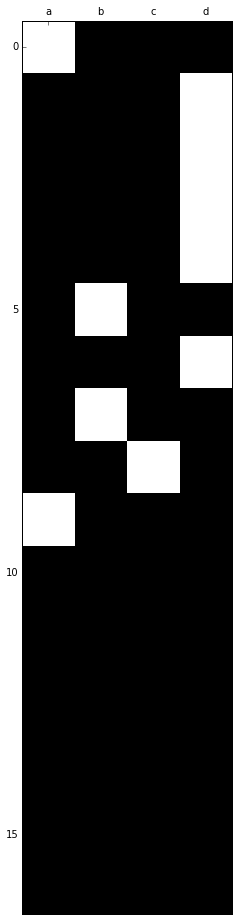

In [20]:
plot_encoded_sequence(X_short_train[0])

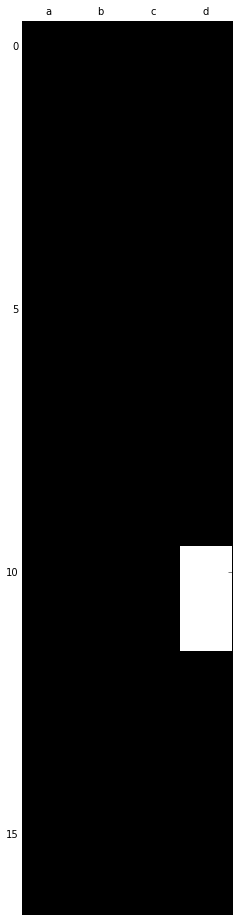

In [21]:
plot_encoded_sequence(Y_short_train[0])